# Building Custom Sources with the Filesystem in `dlt`

## What you will learn

You will learn how to:

- Use the `filesystem` resource to build real custom sources
- Apply filters to file metadata (name, size, date)
- Implement and register custom transformers
- Enrich records with file metadata
- Use incremental loading both for files and content


## Setup: Download real data

Install dlt

In [1]:
%%capture
!pip install dlt[duckdb]

We’ll use a real `.parquet` file from [TimeStored.com](https://www.timestored.com/data/sample/userdata.parquet)

In [2]:
!mkdir -p local_data && wget -O local_data/userdata.parquet https://www.timestored.com/data/sample/userdata.parquet

--2025-05-10 09:22:12--  https://www.timestored.com/data/sample/userdata.parquet
Resolving www.timestored.com (www.timestored.com)... 139.162.217.116
Connecting to www.timestored.com (www.timestored.com)|139.162.217.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113629 (111K)
Saving to: ‘local_data/userdata.parquet’

local_data/userdata 100%[===================>] 110.97K   323KB/s    in 0.3s    

2025-05-10 09:22:13 (323 KB/s) - ‘local_data/userdata.parquet’ saved [113629/113629]



## Step 1: Load Parquet file from Local Filesystem

**What the script below does**: Lists and reads all `.parquet` files in `./local_data` and loads them into a table named `userdata`.

In [13]:
import dlt
from dlt.sources.filesystem import filesystem, read_parquet

# Point to the local file directory
fs = filesystem(bucket_url="./local_data", file_glob="**/*.parquet")

# Add a transformer
parquet_data = fs | read_parquet()

# Create and run pipeline
pipeline = dlt.pipeline(pipeline_name="my_pipeline", destination="duckdb")
load_info = pipeline.run(parquet_data.with_name("userdata"))
print(load_info)

# Inspect data
pipeline.dataset().userdata.df().head()

Pipeline my_pipeline load step completed in 0.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset my_pipeline_dataset
The duckdb destination used duckdb:////content/my_pipeline.duckdb location to store data
Load package 1746869249.2080917 is LOADED and contains no failed jobs


,registration_dttm,id,first_name,last_name,email,gender,ip_address,cc,country,birthdate,salary,title,comments,_dlt_load_id,_dlt_id
0,2016-02-03 07:55:29+00:00,1,Amanda,Jordan,ajordan0@com.com,Female,1.197.201.2,6759521864920116,Indonesia,3/8/1971,49756.53,Internal Auditor,1E+02,1746868952.1992881,5+uFDWh+9ttwsg
1,2016-02-03 17:04:03+00:00,2,Albert,Freeman,afreeman1@is.gd,Male,218.111.175.34,,Canada,1/16/1968,150280.17,Accountant IV,,1746868952.1992881,9c193nULB0/4dA
2,2016-02-03 01:09:31+00:00,3,Evelyn,Morgan,emorgan2@altervista.org,Female,7.161.136.94,6767119071901597,Russia,2/1/1960,144972.51,Structural Engineer,,1746868952.1992881,HA5imYfK1teN/w
3,2016-02-03 00:36:21+00:00,4,Denise,Riley,driley3@gmpg.org,Female,140.35.109.83,3576031598965625,China,4/8/1997,90263.05,Senior Cost Accountant,,1746868952.1992881,DElBP0nBDJTtkw
4,2016-02-03 05:05:31+00:00,5,Carlos,Burns,cburns4@miitbeian.gov.cn,,169.113.235.40,5602256255204850,South Africa,,NaN,,,1746868952.1992881,npUxBhyGLH1hPQ


### **Question 1**:

In the `my_pipeline` pipeline, and the `userdata` dataset, what is the ratio of men:women in decimal?

In [14]:
# check out the numbers below and answer 👀
df = pipeline.dataset().userdata.df()
df.groupby("gender").describe()

id                                                              \
        count        mean         std  min     25%    50%     75%     max   
gender                                                                      
        134.0  567.328358  284.932779  5.0  299.25  601.0  834.50   998.0   
Female  964.0  505.215768  291.593999  1.0  259.00  507.5  754.00  1000.0   
Male    902.0  485.532151  284.964792  2.0  233.75  475.0  731.25   996.0   

       salary                                                              \
        count           mean           std       min       25%        50%   
gender                                                                      
          0.0            NaN           NaN       NaN       NaN        NaN   
Female  964.0  143737.761411  79894.015406  12380.49  77727.13  131819.49   
Male    900.0  154647.536444  79280.732459  13268.99  87257.52  157575.99   

                              
              75%        max  
gender                        
              NaN        NaN  
Female  215282.56  286592.99  
Male    223140.16  286061.25

In [24]:
# Count the number of occurrences for each gender
gender_counts = df['gender'].value_counts()

# Get the individual counts
male_count = gender_counts.get('Male', 0)
female_count = gender_counts.get('Female', 0)

# Compute the male-to-female ratio
ratio = male_count / female_count

print(f"Ratio (men:women) = {ratio:.3f}")


Ratio (men:women) = 0.936


## Step 2: Enrich records with file metadata

Let’s add the file name to every record to track the data origin.

In [15]:
@dlt.transformer()
def read_parquet_with_filename(files):
    import pyarrow.parquet as pq
    for file_item in files:
        with file_item.open() as f:
            table = pq.read_table(f).to_pandas()
            table["source_file"] = file_item["file_name"]
            yield table.to_dict(orient="records")

fs = filesystem(bucket_url="./local_data", file_glob="*.parquet")
pipeline = dlt.pipeline("meta_pipeline", destination="duckdb")

load_info = pipeline.run((fs | read_parquet_with_filename()).with_name("userdata"))
print(load_info)

Pipeline meta_pipeline load step completed in 0.35 seconds
1 load package(s) were loaded to destination duckdb and into dataset meta_pipeline_dataset
The duckdb destination used duckdb:////content/meta_pipeline.duckdb location to store data
Load package 1746869262.575257 is LOADED and contains no failed jobs


## Step 3: Filter files by metadata



Only load files matching custom logic:

In [16]:
fs = filesystem(bucket_url="./local_data", file_glob="**/*.parquet")

# Only include files that contain "user" and are < 1MB
fs.add_filter(lambda f: "user" in f["file_name"] and f["size_in_bytes"] < 1_000_000)

pipeline = dlt.pipeline("filtered_pipeline", destination="duckdb")
load_info = pipeline.run((fs | read_parquet()).with_name("userdata_filtered"))
print(load_info)

Pipeline filtered_pipeline load step completed in 0.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset filtered_pipeline_dataset
The duckdb destination used duckdb:////content/filtered_pipeline.duckdb location to store data
Load package 1746869266.2695296 is LOADED and contains no failed jobs


## Step 4: Load files incrementally
Avoid reprocessing the same file twice.

In [17]:
fs = filesystem(bucket_url="./local_data", file_glob="**/*.parquet")
fs.apply_hints(incremental=dlt.sources.incremental("modification_date"))

data = (fs | read_parquet()).with_name("userdata")
pipeline = dlt.pipeline("incremental_pipeline", destination="duckdb")
load_info = pipeline.run(data)
print(load_info)

Pipeline incremental_pipeline load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/incremental_pipeline.duckdb location to store data


## Step 5: Create a custom transformer

Let’s read structured data from `.json` files.

In [18]:
@dlt.transformer(standalone=True)
def read_json(items):
    from dlt.common import json
    for file_obj in items:
        with file_obj.open() as f:
            yield json.load(f)

# Download a JSON file
!wget -O local_data/sample.json https://jsonplaceholder.typicode.com/users

fs = filesystem(bucket_url="./local_data", file_glob="sample.json")
pipeline = dlt.pipeline("json_pipeline", destination="duckdb")

load_info = pipeline.run((fs | read_json()).with_name("users"))
print(load_info)

--2025-05-10 09:27:53--  https://jsonplaceholder.typicode.com/users
Resolving jsonplaceholder.typicode.com (jsonplaceholder.typicode.com)... 104.21.16.1, 104.21.32.1, 104.21.48.1, ...
Connecting to jsonplaceholder.typicode.com (jsonplaceholder.typicode.com)|104.21.16.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘local_data/sample.json’

local_data/sample.j     [ <=>                ]   5.51K  --.-KB/s    in 0s      

2025-05-10 09:27:53 (58.0 MB/s) - ‘local_data/sample.json’ saved [5645]

Pipeline json_pipeline load step completed in 0.13 seconds
1 load package(s) were loaded to destination duckdb and into dataset json_pipeline_dataset
The duckdb destination used duckdb:////content/json_pipeline.duckdb location to store data
Load package 1746869273.8094757 is LOADED and contains no failed jobs


📁 You will see that this file also exists in your local_data directory.

> A **standalone** resource is defined on a function that is top-level in a module (not an inner function) that accepts config and secrets values. Additionally, if the standalone flag is specified, the decorated function signature and docstring will be preserved. `dlt.resource` will just wrap the decorated function, and the user must call the wrapper to get the actual resource.

Let's inspect the `users` table in your DuckDB dataset:

In [19]:
pipeline.dataset().users.df().head()

,id,name,username,email,address__street,address__suite,address__city,address__zipcode,address__geo__lat,address__geo__lng,phone,website,company__name,company__catch_phrase,company__bs,_dlt_load_id,_dlt_id
0,1,Leanne Graham,Bret,Sincere@april.biz,Kulas Light,Apt. 556,Gwenborough,92998-3874,-37.3159,81.1496,1-770-736-8031 x56442,hildegard.org,Romaguera-Crona,Multi-layered client-server neural-net,harness real-time e-markets,1746869041.8395612,eKxii8FFzYK1XQ
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,Victor Plains,Suite 879,Wisokyburgh,90566-7771,-43.9509,-34.4618,010-692-6593 x09125,anastasia.net,Deckow-Crist,Proactive didactic contingency,synergize scalable supply-chains,1746869041.8395612,Im3jw8+WtN1nYg
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,Douglas Extension,Suite 847,McKenziehaven,59590-4157,-68.6102,-47.0653,1-463-123-4447,ramiro.info,Romaguera-Jacobson,Face to face bifurcated interface,e-enable strategic applications,1746869041.8395612,+ZYt1rGqS4y+tw
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,Hoeger Mall,Apt. 692,South Elvis,53919-4257,29.4572,-164.2990,493-170-9623 x156,kale.biz,Robel-Corkery,Multi-tiered zero tolerance productivity,transition cutting-edge web services,1746869041.8395612,SrDEXtgQMZFluQ
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,Skiles Walks,Suite 351,Roscoeview,33263,-31.8129,62.5342,(254)954-1289,demarco.info,Keebler LLC,User-centric fault-tolerant solution,revolutionize end-to-end systems,1746869041.8395612,rkknO27ceo8pEg


## Step 6: Copy files before loading

Copy files locally as part of the pipeline. This is useful for backups or post-processing.


In [20]:
import os
from dlt.sources.filesystem import filesystem
from dlt.common.storages.fsspec_filesystem import FileItemDict

def copy_local(item: FileItemDict) -> FileItemDict:
    local_path = os.path.join("copied", item["file_name"])
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    item.fsspec.download(item["file_url"], local_path)
    return item

fs = filesystem(bucket_url="./local_data", file_glob="**/*.parquet").add_map(copy_local)
pipeline = dlt.pipeline("copy_pipeline", destination="duckdb")
load_info = pipeline.run(fs.with_name("copied_files"))
print(load_info)

Pipeline copy_pipeline load step completed in 0.08 seconds
1 load package(s) were loaded to destination duckdb and into dataset copy_pipeline_dataset
The duckdb destination used duckdb:////content/copy_pipeline.duckdb location to store data
Load package 1746869280.605155 is LOADED and contains no failed jobs


## Next steps

- Try building a transformer for `.xml` using `xmltodict`
- Combine multiple directories or buckets in a single pipeline
- Explore [more examples](https://dlthub.com/docs/dlt-ecosystem/verified-sources/filesystem/advanced)


✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/14br3TZTRFwTSwpDyom7fxlZCeRF4efMk#forceEdit=true&sandboxMode=true)!

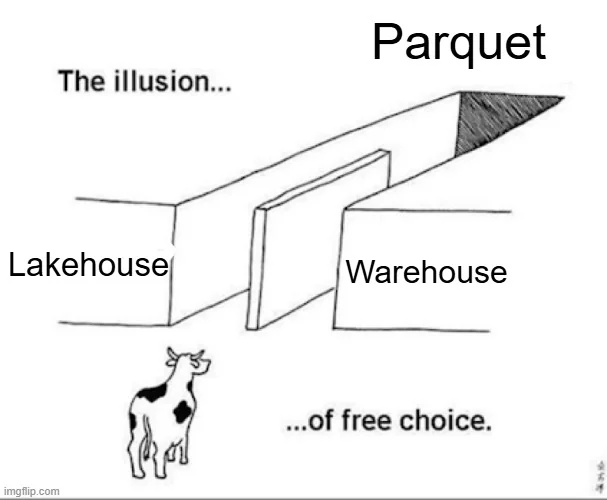